The data contains primarily prices, room descriptions and customer reviews of hotels in  Berlin, London, Madrid, Paris and Rome. 
The goal of this project is to extract and transform data from json files in a way which will enable easily performing comparisons between prices of hotels of different standards (ratings) or between different cities. 

- The user of the data should be able to load the data with the simple call to read_csv or by double clicking and using spreadsheet.

In [41]:
import json
from typing import List
import sys
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sys.path.append('/home/krzysiek/Desktop/projects_etc/football/football_new')
from slicing_diction import slicing_diction
from intersection import intersection_of_n_sets
from datetime import datetime
from pandas.io.json import json_normalize
import numpy as np

In [5]:
# Load JSON data from file
with open('/home/krzysiek/Desktop/projects_etc/data_cleaning/hotels/Berlin.json') as file:
    json_data = json.load(file)
#_
# Normalize the JSON data
berlin_hotels = pd.json_normalize(json_data, sep = '_')

In [19]:
berlin_hotels.head()

,airbnbHotels,bookingHotels,hotelsComHotels
0,[{'thumbnail': 'https://a0.muscache.com/im/pic...,[{'thumbnail': 'https://cf.bstatic.com/xdata/i...,"[{'title': 'Moxy Berlin Ostbahnhof', 'isAd': T..."


In [7]:
berlin_hotels.shape

(1, 3)

In [8]:
def extract_values_of_single_row_df(df, col_idx = None) -> list :
    
    """
    Parameters
    ----------
    df : pd.DataFrame.
    col_idx : None or int. Defaults to None.
              The index of the column to extract
              data from.
    """
    
    if col_idx is None :
        nest_iterab = [df.iloc[0, i] for i in range(df.shape[1])]
        flat_iterab = [elem for iterab in nest_iterab for elem in iterab]
        
        return flat_iterab
    
    return df.iloc[0, col_idx]

In [9]:
def get_keys_of_jsons(jasons_iterab) :
    
    """
    Takes a list of json files and
    returns a list of outermost keys of the 
    jsons in that list.
    

    Parameters
    ----------
    jasons_iterab : list. A list of json files.
    
    Returns
    list. List of outermost keys of the jsons in the list.
    
    Example
    -------
    json_iterab = berlin_hotels.iloc[0,2]
    json_iterab[ : 1]
        
        [{'title': 'Moxy Berlin Ostbahnhof',
          'isAd': True,
          'location': 'Friedrichshain',
          'snippet': {'title': 'Lifestyle Hotel close to Ostbahnhof',
           'text':'Stylish, pet-friendly hotel in Friedrichshain-Kreuzberg connected to...'},
          'paymentOptions': [],
          'highlightedAmenities': [],
          'price': {'currency': '$', 'value': 107, 'withTaxesAndCharges': 120},
          'rating': {'score': 8.8, 'reviews': 596},
          'link': 'https://www.hotels.com/ho497828896/moxy-berlin-ostbahnhof-berlin-germany/'}]
        
        
    get_keys_of_jsons(json_iterab)
    
        
        ['title',
         'isAd',
         'location',
         'snippet',
         'paymentOptions',
         'highlightedAmenities',
         'price',
         'rating',
         'link']
    """
    
    keys = []

    for b in jasons_iterab :
        for k in b.keys() :
            if k not in keys :
                keys.append(k)
    return keys

In [10]:
def get_keys_of_jsons_in_single_row_df(df, col_idx) -> list :
    
    """
    Parameters
    ----------
    df : pd.DataFrame.
    """
    
    jsons_iterab = extract_values_of_single_row_df(df = df, col_idx = col_idx)
    keys = get_keys_of_jsons(jsons_iterab)
    
    return keys
    
    

In [11]:
def get_df_from_jsons_in_single_col_in_single_row_df(df, col_idx,\
                                                     include_nans = True) -> pd.DataFrame :
    
    """
    Parameters
    ----------
    df : pd.DataFrame.
    col_idx : None or int. Defaults to None.
              The index of the column to extract
              data from.
    include_nans : bool. Defaults to True.
    
    Returns
    -------
    pd.DataFrame.
    """
    
    keys = get_keys_of_jsons_in_single_row_df(df = df, col_idx = col_idx)
    blank_vals = [ [ ] for _ in range(len(keys))]
    diction = dict(zip(keys, blank_vals))

    for b in df.iloc[0, col_idx] :
        for key, val in b.items() :
            diction[key].append(val)
    
    lengths_by_keys = {k : len(v) for k, v in diction.items()}
    lengths_max = max([v for v in lengths_by_keys.values()])
    
    if include_nans :
        pairs_with_shorter_vals = {k : v for k, v in lengths_by_keys.items()\
                                  if v < lengths_max}
        
        pairs_shorter_vals_deficit = {k : lengths_max - v for k, v in\
                                      pairs_with_shorter_vals.items()}
        
        for k, v in pairs_shorter_vals_deficit.items() :
            diction[k] = diction[k] + [np.nan for _ in range(v)]
    else :
        for k in keys_with_shorter_vals :
            del diction[k]
    
    return pd.DataFrame(diction)

In [12]:
get_keys_of_jsons(berlin_hotels.iloc[0, 0])

['thumbnail', 'title', 'subtitles', 'price', 'rating', 'link']

The problem is that in every column there are data from different hotel, and the jasons have different keys.
So if we try to make one big df out of it, some jsons will have 0 length values, and therefore we get ValueError when creating a df. So we need to create separate df for every column.

In [13]:
berlin_hotels.iloc[0, 1]

[{'thumbnail': 'https://cf.bstatic.com/xdata/images/hotel/square200/350641744.webp?k=2c9f1df5eea921229bba1b50170ba7dbf054f99c4bf35cd49a6da68a60cc507b&o=&s=1',
  'title': 'Scandic Berlin Kurfürstendamm',
  'stars': None,
  'preferredBadge': True,
  'promotedBadge': True,
  'location': 'Charlottenburg-Wilmersdorf, Berlin',
  'subwayAccess': True,
  'sustainability': 'Travel Sustainable property',
  'distanceFromCenter': 3.2,
  'highlights': ['Standard Double Room',
   'Beds: 1 double or 2 twins',
   'FREE cancellation • No prepayment needed',
   'Only 4 rooms left at this price on our site'],
  'price': {'currency': 'US$', 'value': 111, 'taxesAndCharges': None},
  'rating': {'score': 8.1, 'scoreDescription': 'Very Good', 'reviews': 6506},
  'link': 'https://www.booking.com/hotel/de/scandic-kurfurstendamm.html?lang=en-us'},
 {'thumbnail': 'https://cf.bstatic.com/xdata/images/hotel/square200/25888659.webp?k=d13405d423159c0b5318c5cc1c71acc9751134c75e8e9a17145a620b0995881c&o=&s=1',
  'title'

In [14]:
keys_by_diction_idx = {}

for i, d in enumerate(berlin_hotels.iloc[0, 1]) :
    keys_by_diction_idx[i] = [k for k in d.keys()]
    
    

In [15]:
{len(v) for v in keys_by_diction_idx.values()}

{12, 13}

In [16]:
for v in keys_by_diction_idx.values() :
    print()
    print(v, len(v))
    print()


['thumbnail', 'title', 'stars', 'preferredBadge', 'promotedBadge', 'location', 'subwayAccess', 'sustainability', 'distanceFromCenter', 'highlights', 'price', 'rating', 'link'] 13


['thumbnail', 'title', 'stars', 'preferredBadge', 'promotedBadge', 'location', 'subwayAccess', 'distanceFromCenter', 'highlights', 'price', 'rating', 'link'] 12


['thumbnail', 'title', 'stars', 'preferredBadge', 'promotedBadge', 'location', 'subwayAccess', 'distanceFromCenter', 'highlights', 'price', 'rating', 'link'] 12


['thumbnail', 'title', 'stars', 'preferredBadge', 'promotedBadge', 'location', 'subwayAccess', 'sustainability', 'distanceFromCenter', 'highlights', 'price', 'rating', 'link'] 13


['thumbnail', 'title', 'stars', 'preferredBadge', 'promotedBadge', 'location', 'subwayAccess', 'sustainability', 'distanceFromCenter', 'highlights', 'price', 'rating', 'link'] 13


['thumbnail', 'title', 'stars', 'preferredBadge', 'promotedBadge', 'location', 'subwayAccess', 'sustainability', 'distanceFromCent

['thumbnail', 'title', 'stars', 'preferredBadge', 'promotedBadge', 'location', 'subwayAccess', 'sustainability', 'distanceFromCenter', 'highlights', 'price', 'rating', 'link'] 13


['thumbnail', 'title', 'stars', 'preferredBadge', 'promotedBadge', 'location', 'subwayAccess', 'distanceFromCenter', 'highlights', 'price', 'rating', 'link'] 12


['thumbnail', 'title', 'stars', 'preferredBadge', 'promotedBadge', 'location', 'subwayAccess', 'distanceFromCenter', 'highlights', 'price', 'rating', 'link'] 12


['thumbnail', 'title', 'stars', 'preferredBadge', 'promotedBadge', 'location', 'subwayAccess', 'distanceFromCenter', 'highlights', 'price', 'rating', 'link'] 12


['thumbnail', 'title', 'stars', 'preferredBadge', 'promotedBadge', 'location', 'subwayAccess', 'sustainability', 'distanceFromCenter', 'highlights', 'price', 'rating', 'link'] 13


['thumbnail', 'title', 'stars', 'preferredBadge', 'promotedBadge', 'location', 'subwayAccess', 'distanceFromCenter', 'highlights', 'price', 'rating',

In [17]:
get_keys_of_jsons_in_single_row_df(berlin_hotels, 2)

['title',
 'isAd',
 'location',
 'snippet',
 'paymentOptions',
 'highlightedAmenities',
 'price',
 'rating',
 'link']

In [18]:
df.head(2)

NameError: name 'df' is not defined

In [ ]:
get_keys_of_jsons_in_single_row_df(berlin_hotels)

In [ ]:
berlin_hotels.iloc[0,1]

In [ ]:
keys = get_keys_of_jsons(berlin_hotels.iloc[0,0])

     # to enable getting data from every column of a df
        for i in range(df.shape[1]) :

In [ ]:
berlin_hotels.iloc[0, 0]

In [ ]:
fram = get_df_from_jsons_in_single_col_in_single_row_df(berlin_hotels, 0)

In [33]:
def expand_dictionary_column(df_col) :
    
    """
    Parameters
    ----------
    df_col : pd.Series.
    
    Returns
    -------
    pd.DataFrame.
    
    Example
    -------
    print(df)
    
            column_with_dict
        0  {'currency': '$', 'value': 31, 'period': 'night'}
        1    {'currency': '€', 'value': 45, 'period': 'day'}
        2  {'currency': '$', 'value': 17, 'period': 'night'
    
    print(expand_dictionary_column(df['column_with_dict']))
       

          column_with_dict_currency  column_with_dict_value column_with_dict_period  
        0                         $                      31                   night  
        1                         €                      45                     day  
        2                         $                      17                   night
    
    """
    # Extract the column values as a Series
    column = df_col

    # Get all unique keys from the dictionaries
    all_keys = set().union(*(d.keys() for d in column))
    
    df = pd.DataFrame()

    # Create new columns for each key in the dictionary
    for key in all_keys:
        new_column_name = f"{df_col.name}_{key}"
        df[new_column_name] = [d.get(key) for d in column]

    return df

def expand_diction_columns_inside_df(df, col_names : list) :
    
    """
    Parameters
    ----------
    df : pd.DataFrame.
    col_names : list.
    
    """
    
    new_frames = [expand_dictionary_column(df[cn]) for cn in col_names]
    new_big_frame = pd.concat([df, pd.concat(new_frames, axis = 1)], axis = 1)
    
    
    return new_big_frame

def find_dictionary_columns(df) -> list :
    
    """
    Parameters
    ----------
    df : pd.DataFrame.
    
    Returns
    -------
    list.
    
    Example
    -------
    find_dictionary_columns(df)
        
        ['price']

    """
    
    dictionary_columns = []

    # Iterate over each column
    for column in df.columns :
        if df[column].dtype == 'object' :
            is_dictionary_column = all(value.startswith('{')\
                                       and value.endswith('}')\
                                       for value in df[column].astype(str))
            if is_dictionary_column :
                dictionary_columns.append(column)

    return dictionary_columns

def get_clean_df_from_jsons_in_single_col_in_single_row_df(df, col_idx, include_nans = True) :
    
    """
    Parameters
    ----------
    df : pd.DataFrame.
    col_idx : None or int. Defaults to None.
              The index of the column to extract
              data from.
    include_nans : bool. Defaults to True.
    
    Returns
    -------
    pd.DataFrame.
    """
    
    frame = get_df_from_jsons_in_single_col_in_single_row_df(df = df, col_idx = col_idx,\
                                                             include_nans = include_nans)
    
    diction_cols = find_dictionary_columns(df = frame)
    new_frame = expand_diction_columns_inside_df(df = frame, col_names = diction_cols)
    
    return new_frame

def get_clean_frames_from_jsons_in_single_row_df(df, include_nans = True) :
    
    """
    Parameters
    ----------
    df : pd.DataFrame.
    col_idx : None or int. Defaults to None.
              The index of the column to extract
              data from.
    include_nans : bool. Defaults to True.
    
    Returns
    -------
    tuple. Tuple of dataframes, one for each column in input df.
    """
    
    return tuple([get_clean_df_from_jsons_in_single_col_in_single_row_df(df = df, col_idx = i)\
                 for i in range(df.shape[1])])
    

In [20]:
berlin_hotels.head()

,airbnbHotels,bookingHotels,hotelsComHotels
0,[{'thumbnail': 'https://a0.muscache.com/im/pic...,[{'thumbnail': 'https://cf.bstatic.com/xdata/i...,"[{'title': 'Moxy Berlin Ostbahnhof', 'isAd': T..."


In [42]:
help(intersection_of_n_sets)

Help on function intersection_of_n_sets in module intersection:

intersection_of_n_sets(iterable_of_sets:list) -> set
    Takes a list of sets and returns the intersection
    of those sets.
    
    Parameters
    ----------
    iterable_of_sets : list.
    
    Returns
    -------
    set.



In [44]:
intersection_of_n_sets([{c for c in airbnb.columns}, {c for c in booking.columns}, {c for c in hotelscom.columns}])

{'link', 'price', 'price_currency', 'price_value', 'rating', 'title'}

In [35]:
airbnb, booking, hotelscom = get_clean_frames_from_jsons_in_single_row_df(berlin_hotels)

In [45]:
booking.head()

,thumbnail,title,stars,preferredBadge,promotedBadge,location,subwayAccess,sustainability,distanceFromCenter,highlights,price,rating,link,price_value,price_currency,price_taxesAndCharges,rating_reviews,rating_scoreDescription,rating_score
0,https://cf.bstatic.com/xdata/images/hotel/squa...,Scandic Berlin Kurfürstendamm,NaN,True,True,"Charlottenburg-Wilmersdorf, Berlin",True,Travel Sustainable property,3.2,"[Standard Double Room, Beds: 1 double or 2 twi...","{'currency': 'US$', 'value': 111, 'taxesAndCha...","{'score': 8.1, 'scoreDescription': 'Very Good'...",https://www.booking.com/hotel/de/scandic-kurfu...,111,US$,NaN,6506,Very Good,8.1
1,https://cf.bstatic.com/xdata/images/hotel/squa...,Hotel Karlshorst,3.0,False,False,"Lichtenberg, Berlin",False,Travel Sustainable property,10.7,"[Comfort Double Room, Beds: 1 double or 2 twin...","{'currency': 'US$', 'value': 68, 'taxesAndChar...","{'score': 6.8, 'scoreDescription': 'Review sco...",https://www.booking.com/hotel/de/thang-long-re...,68,US$,3.0,1254,Review score,6.8
2,https://cf.bstatic.com/xdata/images/hotel/squa...,Jugendherberge Berlin Ostkreuz,3.0,False,False,"Lichtenberg, Berlin",False,Travel Sustainable property,6.5,"[Triple Room, 3 beds (1 twin, 2 bunk beds)]","{'currency': 'US$', 'value': 104, 'taxesAndCha...","{'score': 8.4, 'scoreDescription': 'Very Good'...",https://www.booking.com/hotel/de/jugendherberg...,104,US$,NaN,156,Very Good,8.4
3,https://cf.bstatic.com/xdata/images/hotel/squa...,Hollywood Media Hotel am Kurfürstendamm,4.0,True,False,"Charlottenburg-Wilmersdorf, Berlin",True,Travel Sustainable property,4.1,"[Standard Double or Twin Room, Beds: 1 double ...","{'currency': 'US$', 'value': 100, 'taxesAndCha...","{'score': 8.3, 'scoreDescription': 'Very Good'...",https://www.booking.com/hotel/de/hollywood-med...,100,US$,NaN,6679,Very Good,8.3
4,https://cf.bstatic.com/xdata/images/hotel/squa...,Meliá Berlin,4.0,True,True,"Mitte, Berlin",True,Travel Sustainable property,1.0,"[Melia Room, Multiple bed types, Only 1 room l...","{'currency': 'US$', 'value': 135, 'taxesAndCha...","{'score': 8.3, 'scoreDescription': 'Very Good'...",https://www.booking.com/hotel/de/melia-berlin....,135,US$,6.0,5519,Very Good,8.3


In [38]:
booking.isnull().sum() / len(booking)

thumbnail                  0.000
title                      0.000
stars                      0.590
preferredBadge             0.000
promotedBadge              0.000
location                   0.000
subwayAccess               0.000
sustainability             0.324
distanceFromCenter         0.000
highlights                 0.000
price                      0.000
rating                     0.000
link                       0.000
price_value                0.000
price_currency             0.000
price_taxesAndCharges      0.582
rating_reviews             0.000
rating_scoreDescription    0.000
rating_score               0.000
dtype: float64

In [28]:
for i in range(3) :
    print(get_clean_df_from_jsons_in_single_col_in_single_row_df(berlin_hotels, i).iloc[:, 3:].head())

                                               price rating  \
0  {'currency': '$', 'value': 31, 'period': 'night'}      5   
1  {'currency': '$', 'value': 40, 'period': 'night'}   4.96   
2  {'currency': '$', 'value': 108, 'period': 'nig...   4.69   
3  {'currency': '$', 'value': 34, 'period': 'night'}   4.89   
4  {'currency': '$', 'value': 71, 'period': 'night'}   4.87   

                                              link  price_value price_period  \
0  https://www.airbnb.com/rooms/647664199858827562           31        night   
1            https://www.airbnb.com/rooms/41220512           40        night   
2            https://www.airbnb.com/rooms/30881310          108        night   
3             https://www.airbnb.com/rooms/2591901           34        night   
4            https://www.airbnb.com/rooms/19075304           71        night   

  price_currency  
0              $  
1              $  
2              $  
3              $  
4              $  
   preferredBadge  promote

In [27]:
fram.head()

NameError: name 'fram' is not defined

In [129]:
fram.price.astype(str).value_counts()

{'currency': '$', 'value': 57, 'period': 'night'}    10
{'currency': '$', 'value': 63, 'period': 'night'}     7
{'currency': '$', 'value': 76, 'period': 'night'}     7
{'currency': '$', 'value': 38, 'period': 'night'}     7
{'currency': '$', 'value': 81, 'period': 'night'}     7
                                                     ..
{'currency': '$', 'value': 42, 'period': 'night'}     1
{'currency': '$', 'value': 67, 'period': 'night'}     1
{'currency': '$', 'value': 31, 'period': 'night'}     1
{'currency': '$', 'value': 58, 'period': 'night'}     1
{'currency': '$', 'value': 54, 'period': 'night'}     1
Name: price, Length: 99, dtype: int64

In [135]:
find_dictionary_columns(fram)

['price']

In [120]:
fram.price.head()

0    {'currency': '$', 'value': 31, 'period': 'night'}
1    {'currency': '$', 'value': 40, 'period': 'night'}
2    {'currency': '$', 'value': 108, 'period': 'nig...
3    {'currency': '$', 'value': 34, 'period': 'night'}
4    {'currency': '$', 'value': 71, 'period': 'night'}
Name: price, dtype: object

In [117]:
expand_dictionary_column(fram['price'])

,price_currency,price_value,price_period
0,$,31,night
1,$,40,night
2,$,108,night
3,$,34,night
4,$,71,night
...,...,...,...
265,$,53,night
266,$,64,night
267,$,45,night
268,$,126,night


In [123]:
expand_diction_columns_inside_df(fram, ['price'])

,thumbnail,title,subtitles,price,rating,link,price_currency,price_value,price_period
0,https://a0.muscache.com/im/pictures/miso/Hosti...,Private room in Tempelhof,"[Privatzimmer in Tempelhofer Feld, 1 bed, Jul ...","{'currency': '$', 'value': 31, 'period': 'night'}",5,https://www.airbnb.com/rooms/647664199858827562,$,31,night
1,https://a0.muscache.com/im/pictures/b9cb8b8c-5...,Private room in Mitte,"[Tiny, individual Room with private Bathroom, ...","{'currency': '$', 'value': 40, 'period': 'night'}",4.96,https://www.airbnb.com/rooms/41220512,$,40,night
2,https://a0.muscache.com/im/pictures/miso/Hosti...,Hotel room in Prenzlauer Berg,[Serviced Apartment - Studio in Prenzlauer Ber...,"{'currency': '$', 'value': 108, 'period': 'nig...",4.69,https://www.airbnb.com/rooms/30881310,$,108,night
3,https://a0.muscache.com/im/pictures/63522495/a...,Private room in Lichtenberg,"[City East perfectly located, 1 king bed, Jul ...","{'currency': '$', 'value': 34, 'period': 'night'}",4.89,https://www.airbnb.com/rooms/2591901,$,34,night
4,https://a0.muscache.com/im/pictures/miso/Hosti...,Private room in Charlottenburg-Wilmersdorf,[Musical place next to Bundesplatz (U9 & S-Rin...,"{'currency': '$', 'value': 71, 'period': 'night'}",4.87,https://www.airbnb.com/rooms/19075304,$,71,night
...,...,...,...,...,...,...,...,...,...
265,https://a0.muscache.com/im/pictures/417408c6-4...,Private room in Reinickendorf,"[Room in luxury house with breakfast, 3 beds, ...","{'currency': '$', 'value': 53, 'period': 'night'}",4.77,https://www.airbnb.com/rooms/17418993,$,53,night
266,https://a0.muscache.com/im/pictures/miso/Hosti...,Private room in Mitte,"[a cosy, super quiet room in wedding, 2 beds, ...","{'currency': '$', 'value': 64, 'period': 'night'}",4.7,https://www.airbnb.com/rooms/24145048,$,64,night
267,https://a0.muscache.com/im/pictures/5d65188b-3...,Private room in Neukölln,[quiet twin room 3.2 to the courtyard (3rd flo...,"{'currency': '$', 'value': 45, 'period': 'night'}",4.13,https://www.airbnb.com/rooms/26197580,$,45,night
268,https://a0.muscache.com/im/pictures/d81ea04d-b...,Apartment in Mitte,"[Cosy apartment , Berlin city center, 2 beds, ...","{'currency': '$', 'value': 126, 'period': 'nig...",4.69,https://www.airbnb.com/rooms/12843786,$,126,night


In [48]:
blank_vals = [ [ ] for _ in range(len(keys))]
diction = dict(zip(keys, blank_vals))

for b in berlin_hotels.iloc[0,0] :
    for key, val in b.items() :
        diction[key].append(val)

In [49]:
df = pd.DataFrame(diction)
df['subtitles'] = df['subtitles'].apply(lambda iterab : iterab[0])

In [51]:
df

,thumbnail,title,subtitles,price,rating,link
0,https://a0.muscache.com/im/pictures/miso/Hosti...,Private room in Tempelhof,Privatzimmer in Tempelhofer Feld,"{'currency': '$', 'value': 31, 'period': 'night'}",5,https://www.airbnb.com/rooms/647664199858827562
1,https://a0.muscache.com/im/pictures/b9cb8b8c-5...,Private room in Mitte,"Tiny, individual Room with private Bathroom","{'currency': '$', 'value': 40, 'period': 'night'}",4.96,https://www.airbnb.com/rooms/41220512
2,https://a0.muscache.com/im/pictures/miso/Hosti...,Hotel room in Prenzlauer Berg,Serviced Apartment - Studio in Prenzlauer Berg,"{'currency': '$', 'value': 108, 'period': 'nig...",4.69,https://www.airbnb.com/rooms/30881310
3,https://a0.muscache.com/im/pictures/63522495/a...,Private room in Lichtenberg,City East perfectly located,"{'currency': '$', 'value': 34, 'period': 'night'}",4.89,https://www.airbnb.com/rooms/2591901
4,https://a0.muscache.com/im/pictures/miso/Hosti...,Private room in Charlottenburg-Wilmersdorf,Musical place next to Bundesplatz (U9 & S-Ring),"{'currency': '$', 'value': 71, 'period': 'night'}",4.87,https://www.airbnb.com/rooms/19075304
...,...,...,...,...,...,...
265,https://a0.muscache.com/im/pictures/417408c6-4...,Private room in Reinickendorf,Room in luxury house with breakfast,"{'currency': '$', 'value': 53, 'period': 'night'}",4.77,https://www.airbnb.com/rooms/17418993
266,https://a0.muscache.com/im/pictures/miso/Hosti...,Private room in Mitte,"a cosy, super quiet room in wedding","{'currency': '$', 'value': 64, 'period': 'night'}",4.7,https://www.airbnb.com/rooms/24145048
267,https://a0.muscache.com/im/pictures/5d65188b-3...,Private room in Neukölln,quiet twin room 3.2 to the courtyard (3rd floor),"{'currency': '$', 'value': 45, 'period': 'night'}",4.13,https://www.airbnb.com/rooms/26197580
268,https://a0.muscache.com/im/pictures/d81ea04d-b...,Apartment in Mitte,"Cosy apartment , Berlin city center","{'currency': '$', 'value': 126, 'period': 'nig...",4.69,https://www.airbnb.com/rooms/12843786


In [36]:
df['price_usd_night'] = df.price.apply(lambda diction : diction['value'])

In [37]:
df.drop('price',axis=1,inplace=True)

In [38]:
df

,thumbnail,title,subtitles,rating,link,price_usd_night
0,https://a0.muscache.com/im/pictures/miso/Hosti...,Private room in Tempelhof,Privatzimmer in Tempelhofer Feld,5,https://www.airbnb.com/rooms/647664199858827562,31
1,https://a0.muscache.com/im/pictures/b9cb8b8c-5...,Private room in Mitte,"Tiny, individual Room with private Bathroom",4.96,https://www.airbnb.com/rooms/41220512,40
2,https://a0.muscache.com/im/pictures/miso/Hosti...,Hotel room in Prenzlauer Berg,Serviced Apartment - Studio in Prenzlauer Berg,4.69,https://www.airbnb.com/rooms/30881310,108
3,https://a0.muscache.com/im/pictures/63522495/a...,Private room in Lichtenberg,City East perfectly located,4.89,https://www.airbnb.com/rooms/2591901,34
4,https://a0.muscache.com/im/pictures/miso/Hosti...,Private room in Charlottenburg-Wilmersdorf,Musical place next to Bundesplatz (U9 & S-Ring),4.87,https://www.airbnb.com/rooms/19075304,71
...,...,...,...,...,...,...
1615,https://a0.muscache.com/im/pictures/417408c6-4...,Private room in Reinickendorf,Room in luxury house with breakfast,4.77,https://www.airbnb.com/rooms/17418993,53
1616,https://a0.muscache.com/im/pictures/miso/Hosti...,Private room in Mitte,"a cosy, super quiet room in wedding",4.7,https://www.airbnb.com/rooms/24145048,64
1617,https://a0.muscache.com/im/pictures/5d65188b-3...,Private room in Neukölln,quiet twin room 3.2 to the courtyard (3rd floor),4.13,https://www.airbnb.com/rooms/26197580,45
1618,https://a0.muscache.com/im/pictures/d81ea04d-b...,Apartment in Mitte,"Cosy apartment , Berlin city center",4.69,https://www.airbnb.com/rooms/12843786,126


In [39]:
df['rating'] = df['rating'].apply(lambda x : np.nan if x == 'No rating' else x).astype(float)

In [40]:
df.rating.dtype

dtype('float64')

In [41]:
def categorize_ratings(rating : float, left_bound = 1,\
                       right_bound = 5, leng_interv = 0.2) -> list :
    
    """
    Parameters
    ----------
    rating : float. 
    
    Returns
    -------
    
    
    Example
    -------
    categorize_ratings(4)
    
        '4-5'

    """
    
    if (isinstance(rating, str)) | (np.isnan(rating)) :
        return rating
    
    assert rating >= left_bound, "The miniumum rating should equal left_bound !"
    
    if (rating <= left_bound + 1 - 0.01) & (rating >= left_bound) :
        return '{}-{}'.format(left_bound, left_bound + 1)
    elif (rating <= left_bound + 2 - 0.01) & (rating >= left_bound + 1 * leng_interv) :
        return '{}-{}'.format(left_bound + 1, left_bound + 2)
    elif (rating <=  left_bound + 3 - 0.01) & (rating >= left_bound + 2 * leng_interv) :
        return '{}-{}'.format(left_bound + 2, left_bound + 3)
    elif (rating <=  left_bound + 4) & (rating >= left_bound + 3 * leng_interv) :
        return '{}-{}'.format(left_bound + 3, left_bound + 4)    

In [42]:
df.head()

,thumbnail,title,subtitles,rating,link,price_usd_night
0,https://a0.muscache.com/im/pictures/miso/Hosti...,Private room in Tempelhof,Privatzimmer in Tempelhofer Feld,5.00,https://www.airbnb.com/rooms/647664199858827562,31
1,https://a0.muscache.com/im/pictures/b9cb8b8c-5...,Private room in Mitte,"Tiny, individual Room with private Bathroom",4.96,https://www.airbnb.com/rooms/41220512,40
2,https://a0.muscache.com/im/pictures/miso/Hosti...,Hotel room in Prenzlauer Berg,Serviced Apartment - Studio in Prenzlauer Berg,4.69,https://www.airbnb.com/rooms/30881310,108
3,https://a0.muscache.com/im/pictures/63522495/a...,Private room in Lichtenberg,City East perfectly located,4.89,https://www.airbnb.com/rooms/2591901,34
4,https://a0.muscache.com/im/pictures/miso/Hosti...,Private room in Charlottenburg-Wilmersdorf,Musical place next to Bundesplatz (U9 & S-Ring),4.87,https://www.airbnb.com/rooms/19075304,71


In [46]:
df['rating_cat'] = pd.qcut(df.rating, 4, duplicates = 'drop')
#df['rating'].apply(categorize_ratings)

In [47]:
df.head()

,thumbnail,title,subtitles,rating,link,price_usd_night,rating_cat
0,https://a0.muscache.com/im/pictures/miso/Hosti...,Private room in Tempelhof,Privatzimmer in Tempelhofer Feld,5.00,https://www.airbnb.com/rooms/647664199858827562,31,"(4.93, 5.0]"
1,https://a0.muscache.com/im/pictures/b9cb8b8c-5...,Private room in Mitte,"Tiny, individual Room with private Bathroom",4.96,https://www.airbnb.com/rooms/41220512,40,"(4.93, 5.0]"
2,https://a0.muscache.com/im/pictures/miso/Hosti...,Hotel room in Prenzlauer Berg,Serviced Apartment - Studio in Prenzlauer Berg,4.69,https://www.airbnb.com/rooms/30881310,108,"(4.67, 4.83]"
3,https://a0.muscache.com/im/pictures/63522495/a...,Private room in Lichtenberg,City East perfectly located,4.89,https://www.airbnb.com/rooms/2591901,34,"(4.83, 4.93]"
4,https://a0.muscache.com/im/pictures/miso/Hosti...,Private room in Charlottenburg-Wilmersdorf,Musical place next to Bundesplatz (U9 & S-Ring),4.87,https://www.airbnb.com/rooms/19075304,71,"(4.83, 4.93]"


<AxesSubplot:xlabel='rating_cat'>

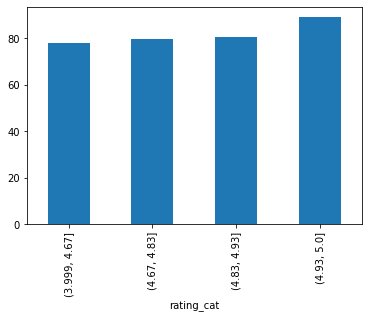

In [48]:
df.groupby('rating_cat')['price_usd_night'].mean().plot.bar()

In [164]:
df.rating.describe()

count    1464.000000
mean        4.776270
std         0.209439
min         4.000000
25%         4.670000
50%         4.830000
75%         4.930000
max         5.000000
Name: rating, dtype: float64